# Predicting risky decision making using fMRI and Recurrent Neural Networks

## Setting Up (Run this block to import, install and download everything necessary)

In [1]:
#Install dependencies
!pip install nilearn --quiet

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from nilearn import plotting, datasets
from nilearn.surface import vol_to_surf

#Figure
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 100

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
RUNS   = ['LR','RL']
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'
# TIP: look inside the data folders for more fine-graned conditions

EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['ment','rnd']}
}

#Downloading Data File
import os, requests

fname = "hcp_task.tgz"
url = "https://osf.io/2y3fw/download"

if not os.path.isfile(fname):
    try:
        r = requests.get(url)
    except requests.ConnectionError:
        print("!!! Failed to download data !!!")
    else:
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
        else:
            with open(fname, "wb") as fid:
                fid.write(r.content)

# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp_task"

# importing the "tarfile" module
import tarfile

# open file
with tarfile.open(fname) as tfile:
  # extracting file
  tfile.extractall('.')

subjects = np.loadtxt(os.path.join(HCP_DIR, 'subjects_list.txt'), dtype='str')

#Loading region info
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

#Help Function
def load_single_timeseries(subject, experiment, run, remove_mean=True):
    """Load timeseries data for a single subject and single run.

    Args:
        subject (str):      subject ID to load
        experiment (str):   Name of experiment
        run (int):          (0 or 1)
        remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

    Returns
        ts (n_parcel x n_timepoint array): Array of BOLD data values

    """
    bold_run  = RUNS[run]
    bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
    bold_file = "data.npy"
    ts = np.load(f"{bold_path}/{bold_file}")
    if remove_mean:
        ts -= ts.mean(axis=1, keepdims=True)
    return ts


def load_evs(subject, experiment, run):
    """Load EVs (explanatory variables) data for one task experiment.

    Args:
        subject (str): subject ID to load
        experiment (str) : Name of experiment
        run (int): 0 or 1

    Returns
        evs (list of lists): A list of frames associated with each condition

    """
    frames_list = []
    task_key = f'tfMRI_{experiment}_{RUNS[run]}'
    for cond in EXPERIMENTS[experiment]['cond']:
        ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
        ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
        ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
        # Determine when trial starts, rounded down
        start = np.floor(ev["onset"] / TR).astype(int)
        # Use trial duration to determine how many frames to include for trial
        duration = np.ceil(ev["duration"] / TR).astype(int)
        # Take the range of frames that correspond to this specific trial
        frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
        frames_list.append(frames)

    return frames_list

# Function to average frames from any given condition
def average_frames(data, evs, experiment, cond):
    idx = EXPERIMENTS[experiment]["cond"].index(cond)
    return np.mean(np.concatenate([np.mean(data[:, evs[idx][i]], axis=1, keepdims=True) for i in range(len(evs[idx]))], axis=-1), axis=1)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 67.4 MB/s eta 0:00:00


## Libraries


In [2]:
import os, requests
import numpy as np
from numpy import interp
from nilearn import datasets, plotting, surface
from nilearn.image import index_img
from nilearn.regions import RegionExtractor
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve, auc, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from keras.optimizers import Adam

## Identifying the DMN Parcel Indices




In [4]:
# Load the region information
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

# Find indices of parcels corresponding to the DMN (labeled as "Default")
DMN_PARCELS = [i for i, network in enumerate(region_info['network']) if network == 'Default']

# Print the indices
print("Indices of parcels corresponding to the DMN:")
print(DMN_PARCELS)

Indices of parcels corresponding to the DMN:
[11, 24, 25, 27, 73, 74, 78, 80, 122, 124, 127, 128, 138, 171, 191, 205, 254, 258, 302, 304, 308, 318, 351]


## Subject IDs

In [5]:
dir = "./hcp_task/subjects"
subject_ids = [f for f in os.listdir(dir) if os.path.isdir(os.path.join(dir, f))]

## Visualizing the DMN




### Setting up

In [ ]:
# NMA provides an atlas
fname = f"{HCP_DIR}/atlas.npz"
url = "https://osf.io/j5kuc/download"

if not os.path.isfile(fname):
    try:
        r = requests.get(url)
    except requests.ConnectionError:
        print("!!! Failed to download data !!!")
    else:
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
        else:
            with open(fname, "wb") as fid:
                fid.write(r.content)

    with np.load(fname) as dobj:
        atlas = dict(**dobj)

In [ ]:
# Load the region information
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

# Find indices of parcels corresponding to the DMN (labeled as "Default")
dmn_indices = [i for i, network in enumerate(region_info['network']) if network == 'Default']

# Prepare the contrast for visualization
group_contrast = np.zeros(len(region_info['name']))
for idx in dmn_indices:
    group_contrast[idx] = 1  # Set DMN parcels to 1

# Fetch the fsaverage surface
fsaverage = datasets.fetch_surf_fsaverage()

# Assuming the correct keys are found, replace 'labels_L' with the appropriate key
# Replace 'labels_L' with the actual key for left hemisphere labels
surf_contrast = group_contrast[atlas["labels_L"] - 1]

### Plot1

In [ ]:
atlas_networks = datasets.fetch_atlas_smith_2009(resting=True, dimension=10)[
    "maps"
]

# min_region_size in voxel volume mm^3
extraction = RegionExtractor(
    atlas_networks,
    min_region_size=800,
    threshold=98,
    thresholding_strategy="percentile",
)

# Just call fit() to execute region extraction procedure
extraction.fit()
regions_img = extraction.regions_img_

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


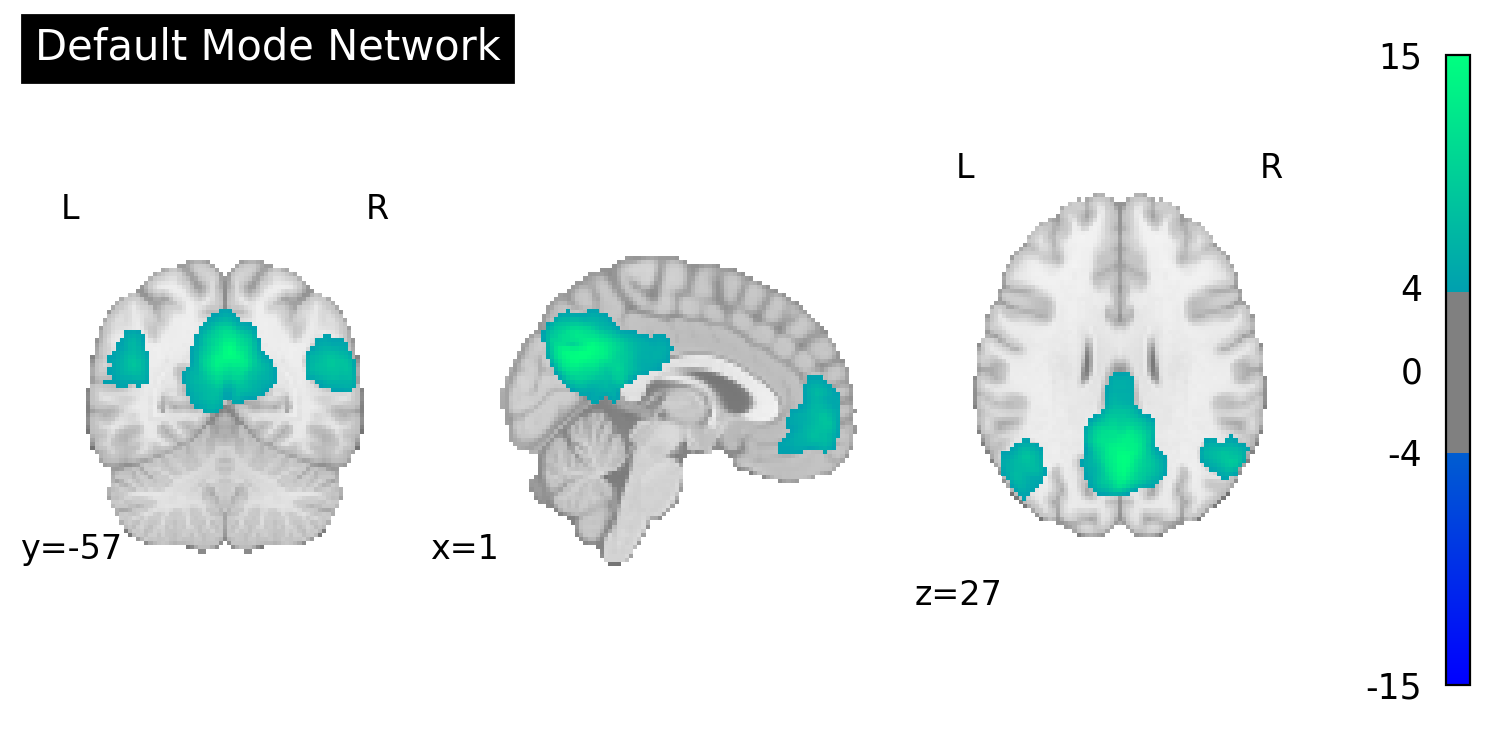

In [ ]:
DMN_network = index_img(atlas_networks, 3)

plotting.plot_stat_map(
    DMN_network,
    title="Default Mode Network",
    draw_cross=False,
    threshold=4,
    cmap="winter"
)

plotting.show()

## Building a GLM and Predicting Gambling Outcomes

### Input/Output

In [ ]:
# Prepare data
X = []  # Independent variables
y = []  # Dependent variable

# Loop through each subject and each run
for subject in subject_ids:
    for run in range(2):  # Assuming there are 2 runs: run 0 and run 1
        timeseries = load_single_timeseries(subject, 'GAMBLING', run)
        evs = load_evs(subject, 'GAMBLING', run)

        for cond_idx, cond in enumerate(EXPERIMENTS['GAMBLING']['cond']):
            average_data = average_frames(timeseries, evs, 'GAMBLING', cond)
            important_data = average_data[DMN_PARCELS]
            X.append(important_data)
            y.append(cond_idx)  # 0 for 'loss', 1 for 'win'

X = np.array(X)
y = np.array(y)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add an intercept
X_scaled = sm.add_constant(X_scaled)

# K-Fold Cross-Validation
n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=10).split(X_scaled, y)

### Training

In [ ]:
accus = []
fprs = []
tprs = []
aucs = []  # AUC values
ppvs = []  # PPV values
npvs = []  # NPV values
senses = []  # Sensitivity values
specs = []  # Specificity values
precisions = []  # Precision values
recalls = []  # Recall values
cms = []  # Confusion Matrices
mean_fpr = np.linspace(0, 1, 100)

for train_index, test_index in kf:
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Specify and adapt GLM model
    model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
    results = model.fit()

    # Predictions based on test data
    preds_prob = results.predict(X_test)
    preds = (preds_prob > 0.5).astype(int)

    accus.append(accuracy_score(y_test, preds))

    fpr, tpr, thresholds = roc_curve(y_test, preds_prob)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs.append(auc(fpr, tpr))

    cm = confusion_matrix(y_test, preds)
    cms.append(confusion_matrix(y_test, preds))

    ppv = cm[1, 1] / (cm[1, 1] + cm[0, 1])
    ppvs.append(ppv)

    npv = cm[0, 0] / (cm[0, 0] + cm[1, 0])
    npvs.append(npv)

    sens = cm[1, 1] / (cm[1, 1] + cm[1, 0])
    senses.append(sens)

    spec = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    specs.append(spec)

    # Calculate precision and recall
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    precisions.append(precision)
    recalls.append(recall)

print("Avg Accuracy:", np.mean(accus))
print("Avg AUC:", np.mean(aucs))
print("Avg PPV:", np.mean(ppvs))
print("Avg NPV:", np.mean(npvs))
print("Avg Sensitivity:", np.mean(senses))
print("Avg Specificity:", np.mean(specs))
print("Avg Precision:", np.mean(precisions))
print("Avg Recall:", np.mean(recalls))

Avg Accuracy: 0.645
Avg AUC: 0.7076604351314482
Avg PPV: 0.6393677754993544
Avg NPV: 0.6460392210129052
Avg Sensitivity: 0.6318786826062368
Avg Specificity: 0.6527107268526032
Avg Precision: 0.6393677754993544
Avg Recall: 0.6318786826062368


### Visualization

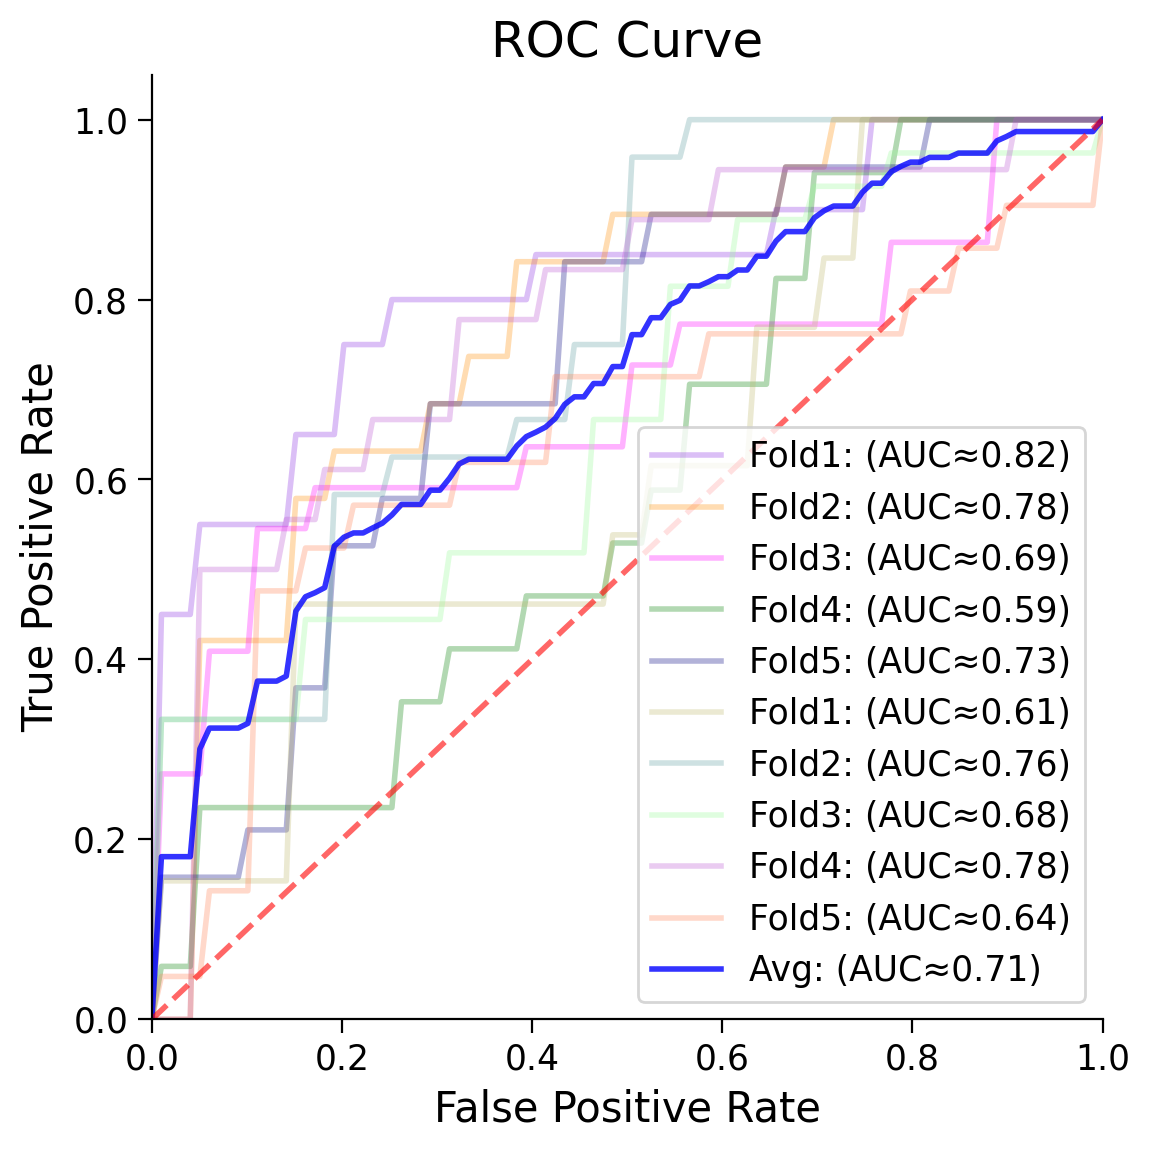

In [ ]:
#Plotting the ROC curve
# ROC Curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.figure(figsize=(6, 6))
plt.plot(mean_fpr, tprs[0], color="blueviolet", label=r"Fold1: (AUC≈%0.2f)" % (aucs[0]), lw=2, alpha=.3)
plt.plot(mean_fpr, tprs[1], color="darkorange", label=r"Fold2: (AUC≈%0.2f)" % (aucs[1]), lw=2, alpha=.3)
plt.plot(mean_fpr, tprs[2], color="magenta", label=r"Fold3: (AUC≈%0.2f)" % (aucs[2]), lw=2, alpha=.3)
plt.plot(mean_fpr, tprs[3], color="green", label=r"Fold4: (AUC≈%0.2f)" % (aucs[3]), lw=2, alpha=.3)
plt.plot(mean_fpr, tprs[4], color="navy", label=r"Fold5: (AUC≈%0.2f)" % (aucs[4]), lw=2, alpha=.3)
plt.plot(mean_fpr, tprs[5], color="darkkhaki", label=r"Fold1: (AUC≈%0.2f)" % (aucs[5]), lw=2, alpha=.3)
plt.plot(mean_fpr, tprs[6], color="cadetblue", label=r"Fold2: (AUC≈%0.2f)" % (aucs[6]), lw=2, alpha=.3)
plt.plot(mean_fpr, tprs[7], color="palegreen", label=r"Fold3: (AUC≈%0.2f)" % (aucs[7]), lw=2, alpha=.3)
plt.plot(mean_fpr, tprs[8], color="mediumorchid", label=r"Fold4: (AUC≈%0.2f)" % (aucs[8]), lw=2, alpha=.3)
plt.plot(mean_fpr, tprs[9], color="coral", label=r"Fold5: (AUC≈%0.2f)" % (aucs[9]), lw=2, alpha=.3)
plt.plot(mean_fpr, mean_tpr, color="blue", label=r"Avg: (AUC≈%0.2f)" % (mean_auc), lw=2, alpha=.8)
plt.plot([0, 1], [0, 1], color="red", lw=2, linestyle="--", alpha=0.6)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

## Building an LSTM and Predicting Gambling Outcomes (Win/Loss)

### Input/Output

In [64]:
# Prepare train data
X = []
y = []

for subject in subject_ids:
    timeseries_run0 = load_single_timeseries(subject, 'GAMBLING', 0)
    timeseries_run1 = load_single_timeseries(subject, 'GAMBLING', 1)
    timeseries = np.concatenate((timeseries_run0, timeseries_run1), axis=1)

    evs_run0 = load_evs(subject, 'GAMBLING', 0)
    evs_run1 = load_evs(subject, 'GAMBLING', 1)
    evs = np.concatenate((evs_run0, evs_run1), axis=0)

    for cond_idx, cond in enumerate(EXPERIMENTS['GAMBLING']['cond']):
        average_data = average_frames(timeseries, evs, 'GAMBLING', cond)
        important_data = average_data[DMN_PARCELS]
        X.append(important_data)
        y.append(cond_idx)

X = np.array(X)
y = np.array(y)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# k-fold cross validation
n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42).split(X_scaled, y)

### Training

In [65]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

accus = []
fprs = []
tprs = []
aucs = []  # AUC values
ppvs = []  # PPV values
npvs = []  # NPV values
senses = []  # Sensitivity values
specs = []  # Specificity values
precisions = []  # Precision values
recalls = []  # Recall values
cms = []  # Confusion Matrices
mean_fpr = np.linspace(0, 1, 100)

for train_idx, test_idx in kf:
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    # Increased regularization
    model = Sequential()
    model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, kernel_regularizer=l2(0.01)))
    model.add(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.01)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    hist = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
    preds_prob = model.predict(X_test).ravel()
    preds = preds_prob.round()

    accus.append(accuracy_score(y_test, preds))

    fpr, tpr, thresholds = roc_curve(y_test, preds_prob)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs.append(auc(fpr, tpr))

    cm = confusion_matrix(y_test, preds)
    cms.append(confusion_matrix(y_test, preds))

    ppv = cm[1, 1] / (cm[1, 1] + cm[0, 1])
    ppvs.append(ppv)

    npv = cm[0, 0] / (cm[0, 0] + cm[1, 0])
    npvs.append(npv)

    sens = cm[1, 1] / (cm[1, 1] + cm[1, 0])
    senses.append(sens)

    spec = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    specs.append(spec)

    # Calculate precision and recall
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    precisions.append(precision)
    recalls.append(recall)

print("Avg Accuracy:", np.mean(accus))
print("Avg AUC:", np.mean(aucs))
print("Avg PPV:", np.mean(ppvs))
print("Avg NPV:", np.mean(npvs))
print("Avg Sensitivity:", np.mean(senses))
print("Avg Specificity:", np.mean(specs))
print("Avg Precision:", np.mean(precisions))
print("Avg Recall:", np.mean(recalls))

Epoch 1/100
5/5 [==============================] - 15s 275ms/step - loss: 1.9351 - accuracy: 0.4306 - val_loss: 1.8626 - val_accuracy: 0.5278
Epoch 2/100
5/5 [==============================] - 0s 18ms/step - loss: 1.8258 - accuracy: 0.5208 - val_loss: 1.7580 - val_accuracy: 0.6667
Epoch 3/100
5/5 [==============================] - 0s 18ms/step - loss: 1.7241 - accuracy: 0.6042 - val_loss: 1.6614 - val_accuracy: 0.6944
Epoch 4/100
5/5 [==============================] - 0s 16ms/step - loss: 1.6298 - accuracy: 0.6736 - val_loss: 1.5721 - val_accuracy: 0.7222
Epoch 5/100
5/5 [==============================] - 0s 16ms/step - loss: 1.5429 - accuracy: 0.7431 - val_loss: 1.4899 - val_accuracy: 0.7222
Epoch 6/100
5/5 [==============================] - 0s 17ms/step - loss: 1.4630 - accuracy: 0.7778 - val_loss: 1.4146 - val_accuracy: 0.7778
Epoch 7/100
5/5 [==============================] - 0s 15ms/step - loss: 1.3898 - accuracy: 0.7639 - val_loss: 1.3453 - val_accuracy: 0.7778
Epoch 8/100
5/5 [=

### Visualization

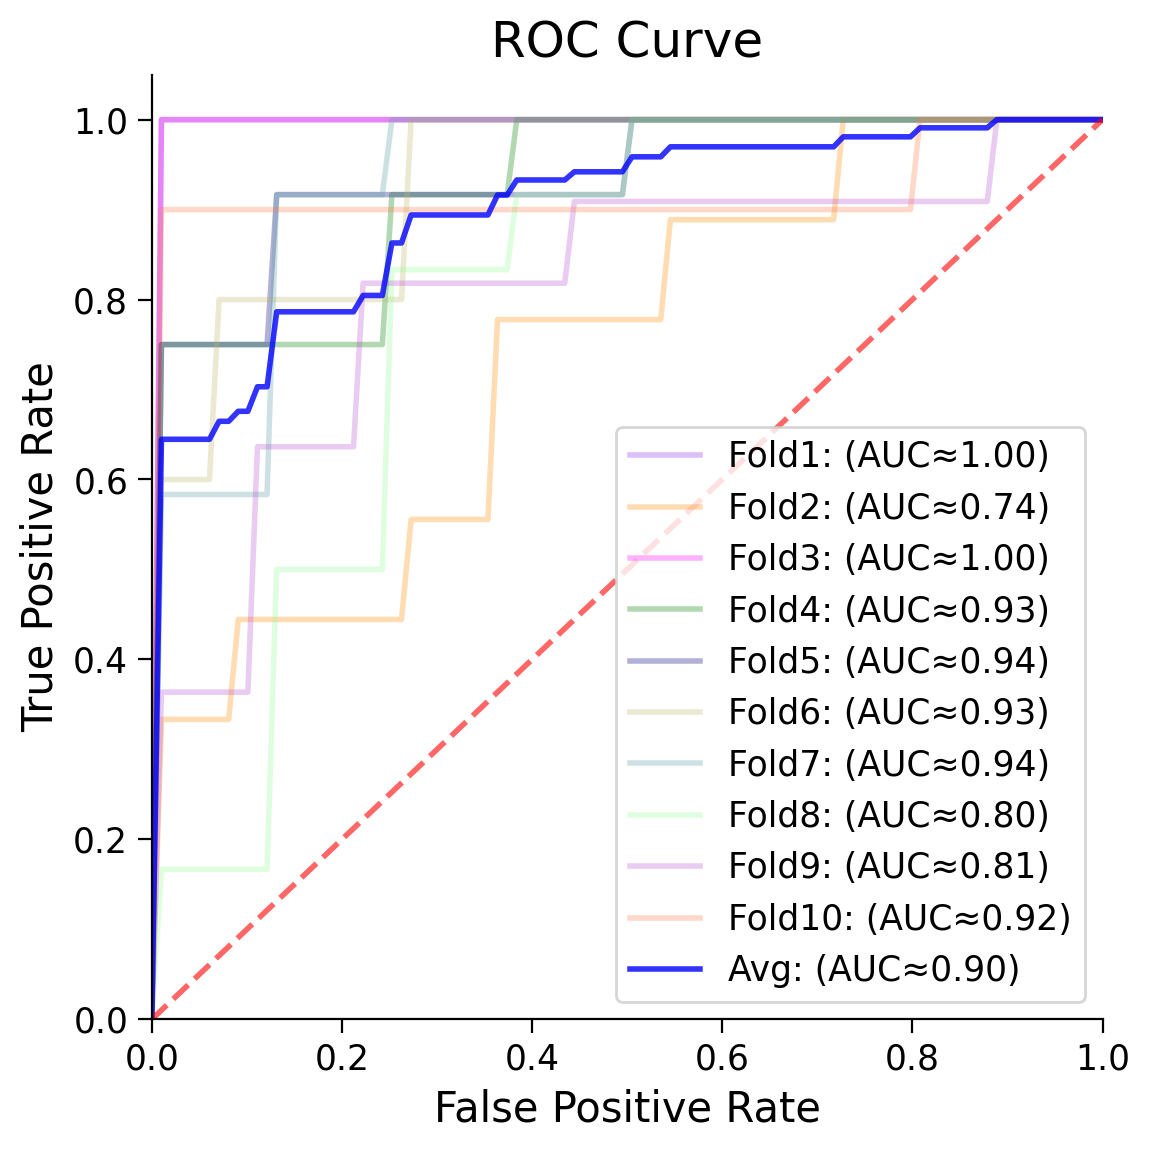

In [66]:
# ROC Curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.figure(figsize=(6, 6))
plt.plot(mean_fpr, tprs[0], color="blueviolet", label=r"Fold1: (AUC≈%0.2f)" % (aucs[0]), lw=2, alpha=.3)
plt.plot(mean_fpr, tprs[1], color="darkorange", label=r"Fold2: (AUC≈%0.2f)" % (aucs[1]), lw=2, alpha=.3)
plt.plot(mean_fpr, tprs[2], color="magenta", label=r"Fold3: (AUC≈%0.2f)" % (aucs[2]), lw=2, alpha=.3)
plt.plot(mean_fpr, tprs[3], color="green", label=r"Fold4: (AUC≈%0.2f)" % (aucs[3]), lw=2, alpha=.3)
plt.plot(mean_fpr, tprs[4], color="navy", label=r"Fold5: (AUC≈%0.2f)" % (aucs[4]), lw=2, alpha=.3)
plt.plot(mean_fpr, tprs[5], color="darkkhaki", label=r"Fold6: (AUC≈%0.2f)" % (aucs[5]), lw=2, alpha=.3)
plt.plot(mean_fpr, tprs[6], color="cadetblue", label=r"Fold7: (AUC≈%0.2f)" % (aucs[6]), lw=2, alpha=.3)
plt.plot(mean_fpr, tprs[7], color="palegreen", label=r"Fold8: (AUC≈%0.2f)" % (aucs[7]), lw=2, alpha=.3)
plt.plot(mean_fpr, tprs[8], color="mediumorchid", label=r"Fold9: (AUC≈%0.2f)" % (aucs[8]), lw=2, alpha=.3)
plt.plot(mean_fpr, tprs[9], color="coral", label=r"Fold10: (AUC≈%0.2f)" % (aucs[9]), lw=2, alpha=.3)
plt.plot(mean_fpr, mean_tpr, color="blue", label=r"Avg: (AUC≈%0.2f)" % (mean_auc), lw=2, alpha=.8)
plt.plot([0, 1], [0, 1], color="red", lw=2, linestyle="--", alpha=0.6)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

#LSTM (Feature Selection) + PCA for Features -> GLM (Win/Loss)

### Input/Output

In [61]:
# Prepare data
X = []  # Independent variables
y = []  # Dependent variable

for subject in subject_ids:
    timeseries_run0 = load_single_timeseries(subject, 'GAMBLING', 0)
    timeseries_run1 = load_single_timeseries(subject, 'GAMBLING', 1)
    timeseries = np.concatenate((timeseries_run0, timeseries_run1), axis=1)

    evs_run0 = load_evs(subject, 'GAMBLING', 0)
    evs_run1 = load_evs(subject, 'GAMBLING', 1)
    evs = np.concatenate((evs_run0, evs_run1), axis=0)

    for cond_idx, cond in enumerate(EXPERIMENTS['GAMBLING']['cond']):
        average_data = average_frames(timeseries, evs, 'GAMBLING', cond)
        important_data = average_data[DMN_PARCELS]
        X.append(important_data)
        y.append(cond_idx)

X = np.array(X)
y = np.array(y)

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Fold Cross-Validation
n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42).split(X_scaled, y)

### Training

In [62]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Lists for saving the results
accus = []
fprs = []
tprs = []
aucs = []  # AUC values
ppvs = []  # PPV values
npvs = []  # NPV values
senses = []  # Sensitivity values
specs = []  # Specificity values
precisions = []  # Precision values
recalls = []  # Recall values
cms = []  # Confusion Matrices
mean_fpr = np.linspace(0, 1, 100)

for train_index, test_index in kf:
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Reshape for LSTM
    X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    # Build the LSTM model with increased regularization
    model = Sequential()
    model.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True, kernel_regularizer=l2(0.01)))
    model.add(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.01)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    hist = model.fit(X_train_lstm, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

    # Using the LSTM to extract features
    feature_model = Sequential(model.layers[:-1])  # Use all layers except the last Dense layer
    X_train_features = feature_model.predict(X_train_lstm)
    X_test_features = feature_model.predict(X_test_lstm)

    # Dimensionality Reduction using PCA
    pca = PCA(n_components=0.95)  # Retain 95% of variance
    X_train_features_pca = pca.fit_transform(X_train_features)
    X_test_features_pca = pca.transform(X_test_features)

    # Scaling the features for GLM
    scaler_features = StandardScaler()
    X_train_features_scaled = scaler_features.fit_transform(X_train_features_pca)
    X_test_features_scaled = scaler_features.transform(X_test_features_pca)

    # Adding an intercept for GLM
    X_train_features_scaled = sm.add_constant(X_train_features_scaled)
    X_test_features_scaled = sm.add_constant(X_test_features_scaled)

    # GLM model
    glm_model = sm.GLM(y_train, X_train_features_scaled, family=sm.families.Binomial())
    glm_results = glm_model.fit()

    # Predictions
    preds_prob = glm_results.predict(X_test_features_scaled)
    preds = (preds_prob > 0.5).astype(int)

    accus.append(accuracy_score(y_test, preds))

    fpr, tpr, thresholds = roc_curve(y_test, preds_prob)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs.append(auc(fpr, tpr))

    cm = confusion_matrix(y_test, preds)
    cms.append(confusion_matrix(y_test, preds))

    ppv = cm[1, 1] / (cm[1, 1] + cm[0, 1])
    ppvs.append(ppv)

    npv = cm[0, 0] / (cm[0, 0] + cm[1, 0])
    npvs.append(npv)

    sens = cm[1, 1] / (cm[1, 1] + cm[1, 0])
    senses.append(sens)

    spec = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    specs.append(spec)

    # Calculate precision and recall
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    precisions.append(precision)
    recalls.append(recall)

print("Avg Accuracy:", np.mean(accus))
print("Avg AUC:", np.mean(aucs))
print("Avg PPV:", np.mean(ppvs))
print("Avg NPV:", np.mean(npvs))
print("Avg Sensitivity:", np.mean(senses))
print("Avg Specificity:", np.mean(specs))
print("Avg Precision:", np.mean(precisions))
print("Avg Recall:", np.mean(recalls))

Epoch 1/100
5/5 [==============================] - 6s 259ms/step - loss: 1.9493 - accuracy: 0.5347 - val_loss: 1.8751 - val_accuracy: 0.5278
Epoch 2/100
5/5 [==============================] - 0s 16ms/step - loss: 1.8390 - accuracy: 0.5833 - val_loss: 1.7696 - val_accuracy: 0.5556
Epoch 3/100
5/5 [==============================] - 0s 12ms/step - loss: 1.7362 - accuracy: 0.6181 - val_loss: 1.6717 - val_accuracy: 0.6389
Epoch 4/100
5/5 [==============================] - 0s 17ms/step - loss: 1.6407 - accuracy: 0.6597 - val_loss: 1.5812 - val_accuracy: 0.7222
Epoch 5/100
5/5 [==============================] - 0s 16ms/step - loss: 1.5526 - accuracy: 0.6597 - val_loss: 1.4979 - val_accuracy: 0.7500
Epoch 6/100
5/5 [==============================] - 0s 18ms/step - loss: 1.4715 - accuracy: 0.6806 - val_loss: 1.4213 - val_accuracy: 0.7778
Epoch 7/100
5/5 [==============================] - 0s 12ms/step - loss: 1.3972 - accuracy: 0.7083 - val_loss: 1.3512 - val_accuracy: 0.8611
Epoch 8/100
5/5 [==

### Visualization

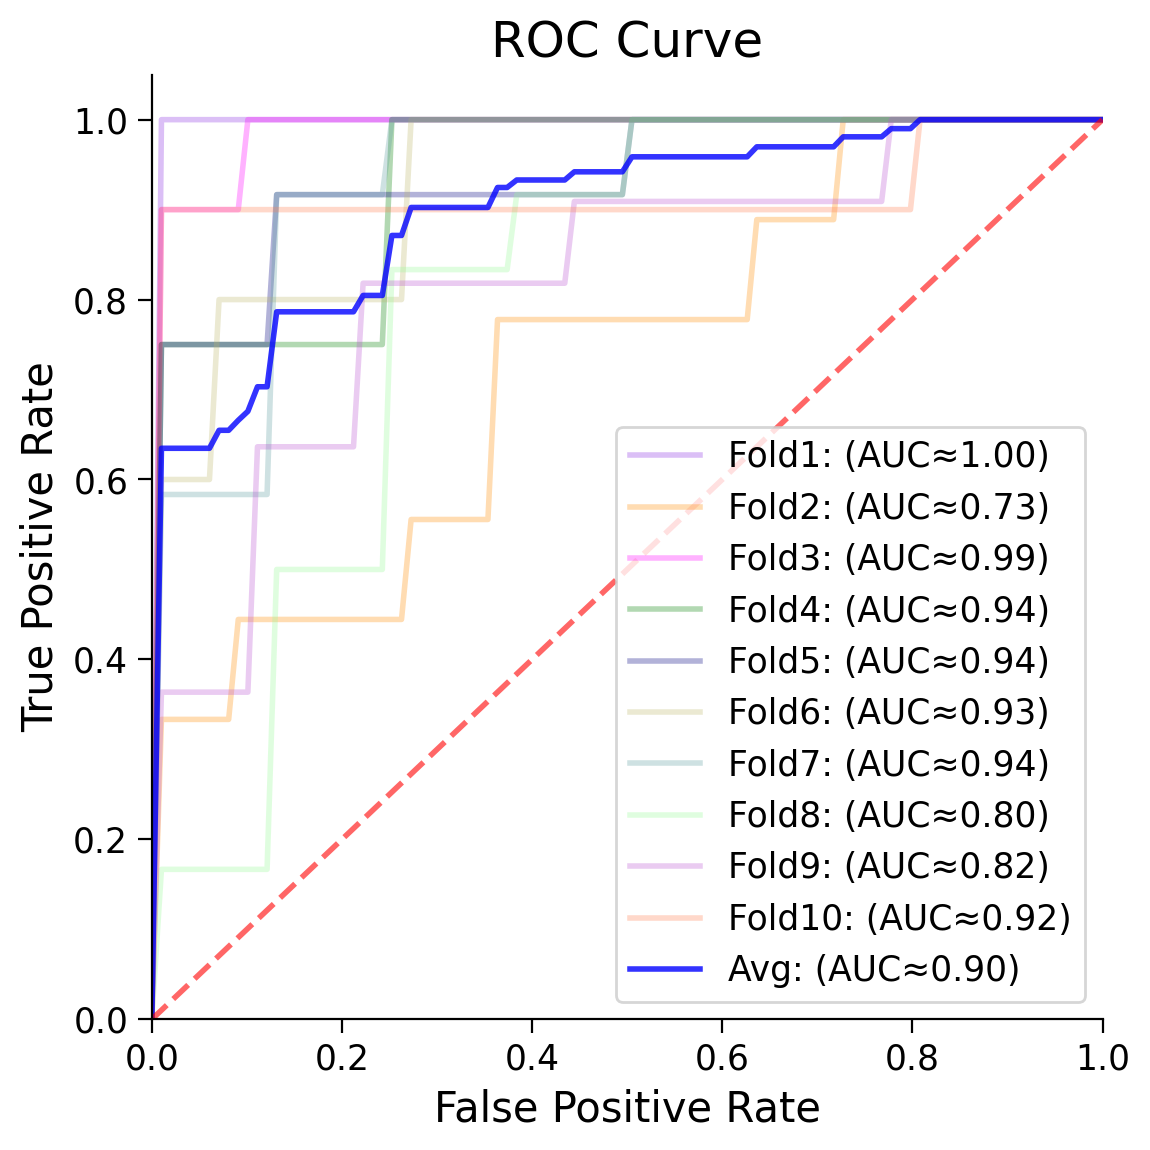

In [63]:
# ROC Curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.figure(figsize=(6, 6))
plt.plot(mean_fpr, tprs[0], color="blueviolet", label=r"Fold1: (AUC≈%0.2f)" % (aucs[0]), lw=2, alpha=.3)
plt.plot(mean_fpr, tprs[1], color="darkorange", label=r"Fold2: (AUC≈%0.2f)" % (aucs[1]), lw=2, alpha=.3)
plt.plot(mean_fpr, tprs[2], color="magenta", label=r"Fold3: (AUC≈%0.2f)" % (aucs[2]), lw=2, alpha=.3)
plt.plot(mean_fpr, tprs[3], color="green", label=r"Fold4: (AUC≈%0.2f)" % (aucs[3]), lw=2, alpha=.3)
plt.plot(mean_fpr, tprs[4], color="navy", label=r"Fold5: (AUC≈%0.2f)" % (aucs[4]), lw=2, alpha=.3)
plt.plot(mean_fpr, tprs[5], color="darkkhaki", label=r"Fold6: (AUC≈%0.2f)" % (aucs[5]), lw=2, alpha=.3)
plt.plot(mean_fpr, tprs[6], color="cadetblue", label=r"Fold7: (AUC≈%0.2f)" % (aucs[6]), lw=2, alpha=.3)
plt.plot(mean_fpr, tprs[7], color="palegreen", label=r"Fold8: (AUC≈%0.2f)" % (aucs[7]), lw=2, alpha=.3)
plt.plot(mean_fpr, tprs[8], color="mediumorchid", label=r"Fold9: (AUC≈%0.2f)" % (aucs[8]), lw=2, alpha=.3)
plt.plot(mean_fpr, tprs[9], color="coral", label=r"Fold10: (AUC≈%0.2f)" % (aucs[9]), lw=2, alpha=.3)
plt.plot(mean_fpr, mean_tpr, color="blue", label=r"Avg: (AUC≈%0.2f)" % (mean_auc), lw=2, alpha=.8)
plt.plot([0, 1], [0, 1], color="red", lw=2, linestyle="--", alpha=0.6)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()



---

